In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import sklearn.preprocessing as preprocessing
%matplotlib inline

# CS5600 Final Project by Jeff Gradner
***
### About
The goal of this project and notebook is to compare the performance of supervised and unsupervised machine learning techniques in classifying whether treatment of an animal will be successful. The data I'm using can be found in `data/raw_data.csv` and is provided by a Utah feedlot operation.
***
### Preprocesing
I'll preprocess the data by adding calculated features, removing features, and performing feature engineering by normalization and standardization. 
***
### Visualization
I'll use Matplotlib to visualize and gain insight from the raw data, processed data and results from different algorithims.
***
### Algorithims
I'll use a variety of different techniques and apply cross-validation and hyperparameter tuning where applicable:
#### Supervised
* K-Nearest Neighbors (KNN)
* Random Forests (RF)
* Radial Basis Function Networks (RBF)
* Neural Networks (NN)
* Support Vector Machines (SVM)
#### Unsupervised
* Gaussian Mixed Models (GMM)
* K-Means (KMeans)
* Primary Component Analysis (PCA)
* Kernel Primary Component Analysis (KPCA)
***
#### Table of Contents
* [Raw Data Visualization](#rawDataVis)
* [Pre-processing](#preprocessing)

<a id="rawDataVis"></a>
# Raw Data Visualization

Below I'm reading the original data into a Pandas DataFrame and assign the dtype to each column based on observing the data in a spreadsheet.

In [115]:
df_raw = pd.read_csv('data/raw_data.csv', dtype={'yard.lot.tag.date':'object',
                                                            'Yard.Lot': 'object',
                                                            'yard.lot.tag':'object',
                                                            'Yard': 'string',
                                                            'Lot': 'string',
                                                            'Treat.Date':'string',
                                                            'Drug': 'string',
                                                            'Treat.Weight':'int64',
                                                            'Treat.Temperature':'float64',
                                                            'Sex': 'string',
                                                            'Treatment.Number':'int64',
                                                            'Head.Received': 'int64',
                                                            'Arrival.Date': 'string',
                                                            'Arrival.Weight':'float64',
                                                            'Death.Date':'object',
                                                            'Cause.Of.Death':'object'},)

## Plotting of the Raw Data

### Quantity of Deaths by Cause per Gender
I see that both male and female cows die majorily from respiratory problems and that more males die than females. H is for hefer and S is for steer.

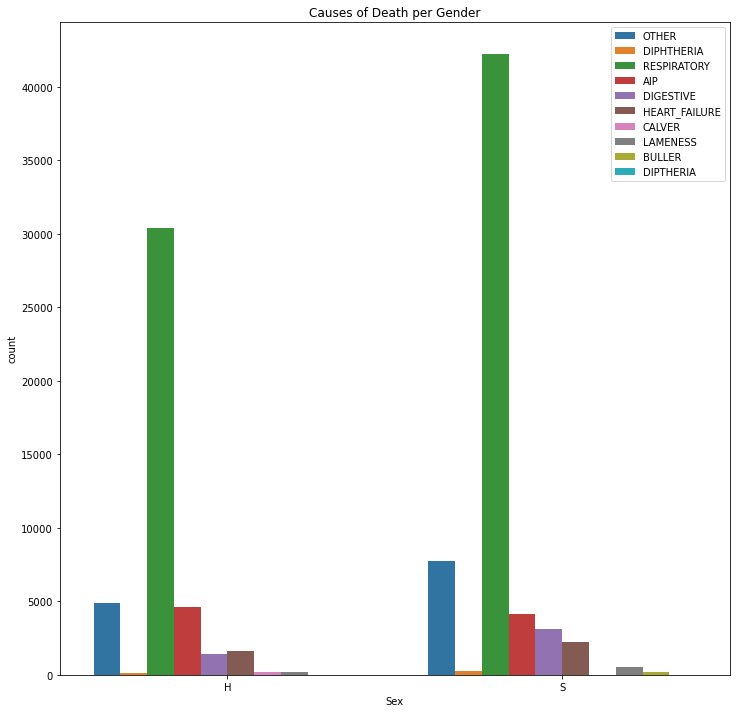

In [116]:
plt.figure(figsize=(12,12))
sns.countplot(x='Sex', hue ='Cause.Of.Death', data=df_raw)
plt.title('Causes of Death per Gender')
plt.legend(loc='best')
plt.show()

## Quantity of Causes of Death per Drug Type
I'm checking for the the largest causes of death, RESPIRATORY, AIP, and OTHER, how many die while being treated with a given drug. 

Below I'm filtering the data to only include examples where the cause of death is one of the 3 top contributors.

In [117]:
df_respiratory = df_raw.loc[df_raw['Cause.Of.Death'] == 'RESPIRATORY']
df_aip = df_raw.loc[df_raw['Cause.Of.Death'] == 'AIP']
df_other = df_raw.loc[df_raw['Cause.Of.Death'] == 'OTHER']
df_deaths_drugs = pd.concat([df_respiratory, df_aip, df_other], axis=0)

Plotting the number of deaths for each cause of death and with what treatment drug was used.

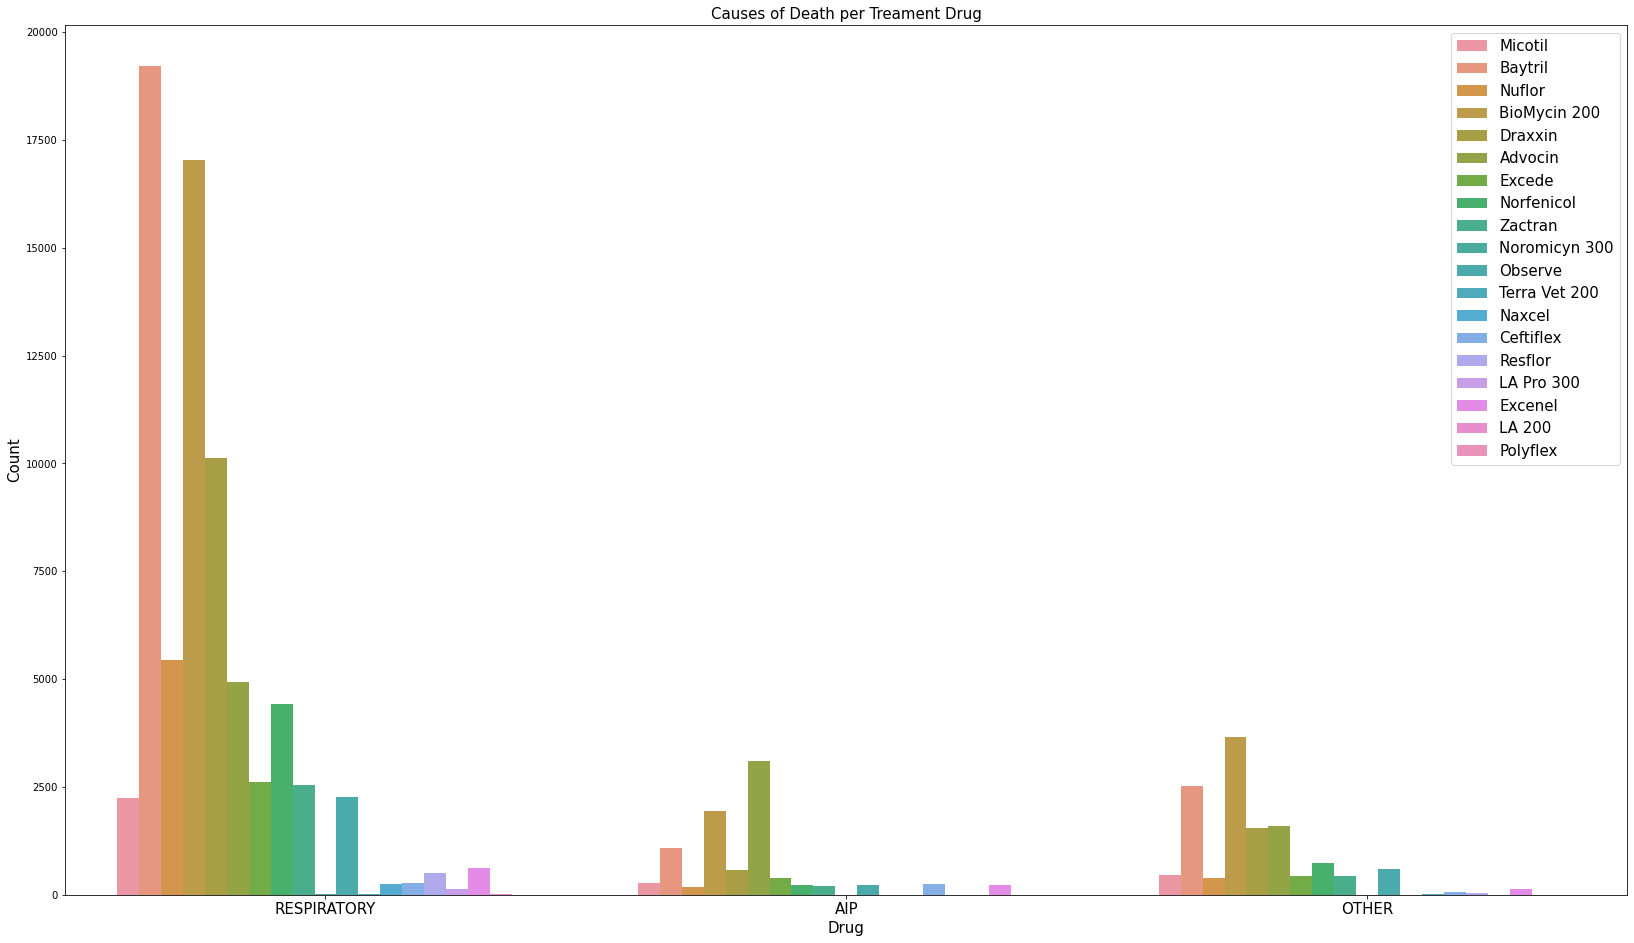

In [118]:
plt.figure(figsize=(28,16))
sns.countplot(x='Cause.Of.Death', hue ='Drug', data=df_deaths_drugs)
plt.title('Causes of Death per Treament Drug',fontsize=15)
plt.legend(loc='upper right',prop={'size':'15'})
plt.xlabel('Drug', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Raw Data Insights

Below is the shape of the original data and a sample of 3 examples.

In [119]:
print("Original data shape:", df_raw.shape)
df_raw.sample(3)

Original data shape: (637742, 16)


,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
419198,1027.9176.2130151.2019-10-03,1027.9176,1027.9176.2130151,1027,9176,10/3/2019,BioMycin 200,936,102.0,H,1,545,7/21/2019,715.0,NaN,NaN
261502,1015.493.52584.2019-12-03,1015.493,1015.493.52584,1015,493,12/3/2019,Draxxin,1144,105.0,S,1,210,10/16/2019,931.0,NaN,NaN
574861,1032.2599.599609.2016-12-15,1032.2599,1032.2599.599609,1032,2599,12/15/2016,Nuflor,610,105.1,S,1,245,12/2/2018,793.0,NaN,NaN


I'm checking if there are any null values and how many of each there are. I see that there are missing values for the Death Date and Cause of Death, this makes sense because not every animal who is treated for Bovine Respiratory Disease dies.

In [120]:
df_raw.isna().sum()

yard.lot.tag.date         0
Yard.Lot                  0
yard.lot.tag              0
Yard                      0
Lot                       0
Treat.Date                0
Drug                      0
Treat.Weight              0
Treat.Temperature         0
Sex                       0
Treatment.Number          0
Head.Received             0
Arrival.Date              0
Arrival.Weight            0
Death.Date           533913
Cause.Of.Death       533913
dtype: int64

Checking how many deaths per Cause of Death. The majority of deaths reported are attributed to respiratory.

In [121]:
df_raw['Cause.Of.Death'].value_counts()

RESPIRATORY      72697
OTHER            12650
AIP               8704
DIGESTIVE         4493
HEART_FAILURE     3851
LAMENESS           663
DIPHTHERIA         388
BULLER             198
CALVER             180
DIPTHERIA            5
Name: Cause.Of.Death, dtype: int64

Viewing how many of each sex exist in the data. 

In [122]:
df_raw['Sex'].value_counts()

S    409015
H    228727
Name: Sex, dtype: Int64

Viewing descriptive statistics from the original data.

In [123]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.0,662.0,789.0,933.0,9955.0
Treat.Temperature,637742.0,104.402306,2.381540,1.0,103.9,104.4,105.1,678.0
Treatment.Number,637742.0,1.476127,0.837107,1.0,1.0,1.0,2.0,20.0
Head.Received,637742.0,232.000260,168.899591,1.0,138.0,202.0,278.0,2171.0
Arrival.Weight,637742.0,718.653705,139.315755,0.0,638.0,724.0,803.0,3482.0


<a id="preprocessing"></a>
# Pre-Processing

In [124]:
df_raw.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death
9225,1001.8973.3938973.2018-05-02,1001.8973,1001.8973.3938973,1001,8973,5/2/2018,Nuflor,846,104.1,S,2,75,1/12/2018,719.0,NaN,NaN
229086,1011.ROD-84.2430.2012-07-01,1011.ROD-84,1011.ROD-84.2430,1011,ROD-84,7/1/2012,Draxxin,596,105.5,S,2,151,5/24/2012,521.0,NaN,NaN
173744,1008.929.57008.2019-08-08,1008.929,1008.929.57008,1008,929,8/8/2019,Advocin,1101,105.9,H,1,295,5/2/2019,804.0,8/14/2019,AIP


Feedlots are made up of yards that contain lots where the animals reside. Each animal has a unique tag. Below I'm taking the series of yard.lot.tag and splitting the data where there are periods to create three series for the yard, lot, and tag. I'm then combining yard and tag into one series named Yard.Tag adding it to the DataFrame and removing the yard and tag columns.

In [125]:
ylt = df_raw['yard.lot.tag']
ylt = ylt.str.split( '.', expand= True)
ylt.rename(columns = {0:'yard', 1:'lot', 2:'tag'}, inplace = True)
df_raw['yard'] = ylt['yard']
df_raw['tag'] = ylt['tag']
df_raw['Yard.Tag'] = df_raw['yard'] + '.' + df_raw['tag']
df_raw = df_raw.drop(['yard', 'tag'], axis = 1)

A target column doesn't exist in the raw data so I'm going to add one named DNF for Did Not Finish. If an example has 0 for its DNF value then the animal finished or lived. If DNF has a value of 1 then that animal died. I construct the DNF series by inserting the value 0 if there is no death date, otherwise 1.

In [126]:
df_raw['DNF'] = ''
df_raw['DNF'] = np.where(pd.isna(df_raw['Death.Date']), 0, 1)

Thinking that the time of year an animal arrives on the feedlot and gets sick could be useful I'm adding features for the arrival month and quarter, and the treat month and quarter. I'm using Pandas to parse the month and quarter from the exising arrival and treat dates. 

In [127]:
df_raw['Arrival.Month'] = pd.DatetimeIndex(df_raw['Arrival.Date']).month
df_raw['Arrival.Quarter'] = pd.DatetimeIndex(df_raw['Arrival.Date']).quarter
df_raw['Treat.Month'] = pd.DatetimeIndex(df_raw['Treat.Date']).month
df_raw['Treat.Quarter'] = pd.DatetimeIndex(df_raw['Treat.Date']).quarter

There will be examples that have the same Yard.Lot if they are treated more than once or are treated once and do not finish. I want all instances for a particular animal to reflect whether they died or not. For example if an animal is treated two times and there is a third input vector that reflects that the animal died then I want all of the instances for that animal to have a DNF value of 1. Below I sort the raw data by Yard.Lot and Treat.Date, I then get a boolean series where examples that have a dupilcate are marked True. These examples that are marked True reflect the cows that need to have their DNF values updated to match the end result for that animal. I then access the raw data with the boolean series and group by the Yard.Lot and Yard.Tag meaning I'm grouping all instances for each unique animal. I then access those groups at their DNF values and apply transform to each group so that if there is a value 1 in any of a groups DNF then all will have the value 1 for DNF. This returns a boolean series where True indicates that all the values were set to 1 and False means the cow finished and all examples for that cow have a DNF of 0. I used this boolean series to update the DNF column as integers 0 or 1.

In [128]:
df_raw = df_raw.sort_values(['Yard.Lot', 'Treat.Date'])
dup = df_raw.duplicated(['Yard.Lot', 'Yard.Tag'], keep=False)
fixed_dnf = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['DNF'].transform(any)
df_raw['DNF'].update(fixed_dnf.astype(int))

Similar to how I want the DNF value to be the same for all examples given a single unique animal I want the death date and cause of death to match for all examples of an animal. Below I use the boolean series `dup` from above which indicated which examples have duplicates or which animals have more than entry in the data. I then group by Yard.Lot and Yard.Tag again where each group consists of examples for a single animal and take the animal death date and fill backwards from the example so that all entries for a single animal have the same death date and then also fill forwards to ensure that any entries after the one marked with the death date also have the death date value. I repeat this process for the cause of death.  

In [129]:
death_date_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='bfill')
df_raw['Death.Date'].update(death_date_fixed1)
death_date_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Death.Date'].fillna(method='ffill')
df_raw['Death.Date'].update(death_date_fixed2)

death_cause_fixed1 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='bfill')
df_raw['Cause.Of.Death'].update(death_cause_fixed1)
death_cause_fixed2 = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag'])['Cause.Of.Death'].fillna(method='ffill')
df_raw['Cause.Of.Death'].update(death_cause_fixed2)

So far all of the examples represent a treatment of a given animal and I want to make sure that the treatment number is correct for all examples. I again use the boolean series dup to get all the instances where they belong to an animal who have more than one entry in the data and group by the Yard.Lot and Yard.Tag and number each item in each group $0$ to $(len(group)-1)$ with Pandas cumcount() function. A treament number wouldn't ever be 0 the first treatment should have a treatment number of 1 so I increment all the values by 1. Finally the Treatment.Number column is replaced with the updated treatment number values.

In [130]:
fixed_treat = df_raw[dup].groupby(['Yard.Lot', 'Yard.Tag']).cumcount()
fixed_treat += 1
df_raw['Treatment.Number'] = fixed_treat

Adding a new row for the death event of each animal if they did not finish. I'm creating a DataFrame of all the examples where the death date is not null and dropping and duplicates of Yard.Lot and Yard.Tag so that the data has one example for each animal that did not finish. Set the treat date equal to the death date because these rows are the death event not a treatment instance. I also set the drug, treat weight, and treat temperature to null (nan). 

In [131]:
df_dnf = df_raw.loc[df_raw['Death.Date'].notna()].drop_duplicates(['Yard.Lot', 'Yard.Tag'])
df_dnf['Treat.Date'] = df_dnf['Death.Date']
df_dnf.loc[:,['Drug', 'Treat.Weight','Treat.Temperature']] = np.nan

Concatenating the death events to the raw data and sorting by Yard.Lot and Treat.Date to observe if it looks correct. It does and then I reset the index after sorting the DataFrame.

In [132]:
df = pd.concat([df_raw, df_dnf], ignore_index=True)
df = df.sort_values(['Yard.Lot', 'Treat.Date'])
df = df.reset_index(drop=True)

Adding another feature Brdcasestothispoint that is the number of BRD cases in a given lot for each example. 

In [133]:
df.loc[:,'Brdcasestothispoint'] = df.groupby(df['Yard.Lot']).cumcount()

Adding another feature that is the number of distinct cases of BRD for a given lot.

In [134]:
unique_cases = df.drop_duplicates(['Yard.Lot', 'Yard.Tag']).groupby(df['Yard.Lot']).cumcount()
distbrd = unique_cases.reindex(df.index).ffill().astype(int)
df['Distbrdcasestothispoint'] = distbrd

Adding two more features, one for the total treatment failures and another for the treatment failures for a given lot

In [135]:
dup = df.duplicated(['Yard.Lot', 'Yard.Tag'])
df['Txfailure2'] = dup.astype(int)
failtothispoint = df.groupby(df['Yard.Lot']).cumsum()['Txfailure2']
df['Txfailure2tothispoint'] = failtothispoint

Adding another feature that is the treatment success rate for a given lot. 

In [136]:
success_rate = (df['Distbrdcasestothispoint']-df['Txfailure2tothispoint'])/df['Distbrdcasestothispoint']
success_rate = success_rate.fillna(1)
success_rate = success_rate.replace(np.NINF, 1)
success_rate = success_rate.replace(np.inf, 1)
df['Txsuccessrate2'] = success_rate

Adding two more features, one for the proportion of BRD cases and another for the proportion of distinct BRD cases for a given lot. 

In [137]:
df['Propbrdcasestothispoint'] = df['Brdcasestothispoint']/df['Head.Received']
df['Propdistcasestothispoint'] = df['Distbrdcasestothispoint']/df['Head.Received']

Adding a days since arrival feature to determine how long the animal has been in the feedlot.

In [138]:
df['Dayssincearrival'] = (pd.to_datetime(df['Treat.Date'])-pd.to_datetime(df['Arrival.Date'])).dt.days

Adding two more features, the amount of deaths and the proportion of deaths.

In [139]:
dnf = df.loc[df['Death.Date'].notna()]
deathcount = df.groupby(df['Yard.Lot'])['DNF'].cumsum()
df['Deathstothispoint'] = deathcount
df['Propdeathstothispoint'] = df['Deathstothispoint']/df['Head.Received']

Adding two more features, the number of animals that were pulled and treated on a given day for a lot and the proportion of pulls for that lot. 

In [140]:
df['Dailyallpulls'] = df.groupby(['Yard.Lot', 'Treat.Date'])['Treat.Date'].transform('size')
df['Propdailyallpulls'] = df['Dailyallpulls']/df['Head.Received']

Viewing a sample of the data.

In [141]:
df.sample(3)

,yard.lot.tag.date,Yard.Lot,yard.lot.tag,Yard,Lot,Treat.Date,Drug,Treat.Weight,Treat.Temperature,Sex,Treatment.Number,Head.Received,Arrival.Date,Arrival.Weight,Death.Date,Cause.Of.Death,Yard.Tag,DNF,Arrival.Month,Arrival.Quarter,Treat.Month,Treat.Quarter,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls
309467,1022.7708.424204.2018-04-15,1022.7708,1022.7708.424204,1022,7708,5/15/2018,NaN,NaN,NaN,S,NaN,236,12/11/2017,818.0,5/15/2018,RESPIRATORY,1022.424204,1,12,4,4,2,34,27,1,7,0.740741,0.144068,0.114407,155,6,0.025424,1,0.004237
159127,1008.2455.08138.2018-04-16,1008.2455,1008.2455.08138,1008,2455,4/16/2018,Micotil,998.0,104.9,S,NaN,908,2/27/2018,762.0,NaN,NaN,1008.08138,0,2,1,4,2,52,39,0,13,0.666667,0.057269,0.042952,48,15,0.016520,1,0.001101
85616,1005.1369.82414.2019-12-12,1005.1369,1005.1369.82414,1005,1369,12/12/2019,BioMycin 200,604.0,102.3,S,2.0,165,12/7/2019,639.0,NaN,NaN,1005.82414,0,12,4,12,4,12,11,1,1,0.909091,0.072727,0.066667,5,0,0.000000,3,0.018182


Dropping columns from the data I won't use or need.

In [142]:
df_reduced = df.drop(['yard.lot.tag.date','Yard', 'Yard.Lot','yard.lot.tag', 'Lot', 'Arrival.Date', 'Arrival.Weight','Yard.Tag','Treat.Date', 'Death.Date', 'Cause.Of.Death'], axis=1)

One hot encoding nominal features and viewing a sample of the data.

In [150]:
df_one_hot = pd.get_dummies(data=df_reduced, columns=['Arrival.Month', 'Arrival.Quarter', 'Treat.Month', 'Treat.Quarter', 'Drug', 'Sex'])
pd.set_option('display.max_columns', 79)
df_one_hot.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,DNF,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls,Arrival.Month_1,Arrival.Month_2,Arrival.Month_3,Arrival.Month_4,Arrival.Month_5,Arrival.Month_6,Arrival.Month_7,Arrival.Month_8,Arrival.Month_9,Arrival.Month_10,Arrival.Month_11,Arrival.Month_12,Arrival.Quarter_1,Arrival.Quarter_2,Arrival.Quarter_3,Arrival.Quarter_4,Treat.Month_1,Treat.Month_2,Treat.Month_3,Treat.Month_4,Treat.Month_5,Treat.Month_6,Treat.Month_7,Treat.Month_8,Treat.Month_9,Treat.Month_10,Treat.Month_11,Treat.Month_12,Treat.Quarter_1,Treat.Quarter_2,Treat.Quarter_3,Treat.Quarter_4,Drug_Advocin,Drug_Baytril,Drug_BioMycin 200,Drug_Ceftiflex,Drug_Draxxin,Drug_Excede,Drug_Excenel,Drug_LA 200,Drug_LA 300,Drug_LA Pro 300,Drug_Micotil,Drug_Naxcel,Drug_Norfenicol,Drug_Noromicyn 300,Drug_Nuflor,Drug_Observe,Drug_Polyflex,Drug_Resflor,Drug_Terra Vet 200,Drug_Zactran,Sex_H,Sex_S
58678,682.0,103.1,NaN,182,0,11,11,0,0,1.000000,0.060440,0.060440,18,0,0.000000,1,0.005495,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
668720,796.0,105.8,NaN,100,0,0,0,0,0,1.000000,0.000000,0.000000,13,0,0.000000,1,0.010000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
663976,802.0,103.1,3.0,323,1,11,7,1,4,0.428571,0.034056,0.021672,71,7,0.021672,1,0.003096,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
271844,NaN,NaN,1.0,152,1,36,28,1,8,0.714286,0.236842,0.184211,13,10,0.065789,8,0.052632,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
260783,1300.0,102.4,NaN,100,0,15,9,0,6,0.333333,0.150000,0.090000,73,0,0.000000,1,0.010000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


Filtering out the numeric features for feature engineering and viewing a sample.

In [151]:
numeric_features = df_one_hot.drop(df_one_hot.iloc[:,17:], axis=1)
numeric_features.drop(columns=['DNF'], axis=1, inplace=True)
numeric_features.sample(5)

,Treat.Weight,Treat.Temperature,Treatment.Number,Head.Received,Brdcasestothispoint,Distbrdcasestothispoint,Txfailure2,Txfailure2tothispoint,Txsuccessrate2,Propbrdcasestothispoint,Propdistcasestothispoint,Dayssincearrival,Deathstothispoint,Propdeathstothispoint,Dailyallpulls,Propdailyallpulls
421563,800.0,105.8,1.0,248,60,49,0,11,0.775510,0.241935,0.197581,29,21,0.084677,17,0.068548
494188,884.0,104.8,2.0,203,1,0,1,1,1.000000,0.004926,0.000000,154,0,0.000000,1,0.004926
320353,910.0,104.9,1.0,220,12,9,0,3,0.666667,0.054545,0.040909,221,7,0.031818,1,0.004545
361370,1153.0,102.0,NaN,139,13,9,0,4,0.555556,0.093525,0.064748,159,6,0.043165,1,0.007194
650326,727.0,107.4,NaN,120,5,4,0,1,0.750000,0.041667,0.033333,25,0,0.000000,2,0.016667


Statistical details of the numeric features.

In [152]:
numeric_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Treat.Weight,637742.0,808.029455,212.499837,-1114.000000,662.000000,789.000000,933.000000,9955.000000
Treat.Temperature,637742.0,104.402306,2.381540,1.000000,103.900000,104.400000,105.100000,678.000000
Treatment.Number,316952.0,1.752300,0.862325,1.000000,1.000000,2.000000,2.000000,11.000000
Head.Received,695716.0,232.950889,169.506711,1.000000,139.000000,203.000000,279.000000,2171.000000
Brdcasestothispoint,695716.0,33.695496,50.729922,0.000000,6.000000,16.000000,40.000000,753.000000
Distbrdcasestothispoint,695716.0,23.751988,32.389729,0.000000,4.000000,12.000000,30.000000,422.000000
Txfailure2,695716.0,0.328259,0.469580,0.000000,0.000000,0.000000,1.000000,1.000000
Txfailure2tothispoint,695716.0,9.943509,20.188924,0.000000,1.000000,3.000000,10.000000,341.000000
Txsuccessrate2,695716.0,0.649426,0.392056,-6.000000,0.500000,0.733333,0.950000,1.000000
Propbrdcasestothispoint,695716.0,0.169560,0.268375,0.000000,0.029787,0.081340,0.195980,5.000000


Checking for null or missing data from the numeric features.

In [153]:
numeric_features.isna().sum()

Treat.Weight                 57974
Treat.Temperature            57974
Treatment.Number            378764
Head.Received                    0
Brdcasestothispoint              0
Distbrdcasestothispoint          0
Txfailure2                       0
Txfailure2tothispoint            0
Txsuccessrate2                   0
Propbrdcasestothispoint          0
Propdistcasestothispoint         0
Dayssincearrival                 0
Deathstothispoint                0
Propdeathstothispoint            0
Dailyallpulls                    0
Propdailyallpulls                0
dtype: int64

Filling missing data with the mean of the feature it belongs to. The mean doesn't tell us anything statisically speaking

In [154]:
numeric_features['Treat.Weight'].fillna(value=numeric_features['Treat.Weight'].mean(), inplace=True)
numeric_features['Treat.Temperature'].fillna(value=numeric_features['Treat.Temperature'].mean(), inplace=True)
numeric_features['Treatment.Number'].fillna(value=numeric_features['Treatment.Number'].mean(), inplace=True)

Using scikit-learn I'm going to normalize and standardize the numeric features. I'll create two datasets so that I can use the scaled or nomalized data depending on the algorithim. I'm storing the numeric feature column names so I can reconstruct a DataFrame with the transformed datasets.

In [156]:
numeric_column_labels = numeric_features.columns
normed_features = preprocessing.normalize(numeric_features)
df_normed = pd.DataFrame((normed_features), columns=numeric_column_labels)
scaled_features = preprocessing.scale(numeric_features)
df_scaled = pd.DataFrame((scaled_features), columns = numeric_column_labels)

Combining the transformed data from above with the nominal features that were one-hot encoded and saving them to CSV files.

In [164]:
normed_processed = pd.concat([df_normed, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
scaled_processed = pd.concat([df_scaled, df_one_hot.iloc[:,17:], df_reduced['DNF']], axis=1, sort=False)
normed_processed.to_csv('data/normed_processed_data.csv', index=False)
scaled_processed.to_csv('data/scaled_processed_data.csv', index=False)